In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from time import time, sleep
from un0usb.fpga_ctrl import FpgaControl

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Global constants
SAMPLES_PER_LINE = 16384
GAINS_MAX = 32
LINES_MAX = 32
SAMPLE_W = 10
SAMPLE_N = 2 ** SAMPLE_W
SAMPLE_FREQ = 63.75

In [3]:
# Utility functions
def line_to_voltage(line):
    return [((2 * 3.3) / SAMPLE_N) * ((w & (SAMPLE_N - 1)) - SAMPLE_N // 2) for w in line]

def gain_to_voltage(gain):
    return [(1.0 / SAMPLE_N) * g for g in gain]

def gain_expand(gain, length=SAMPLES_PER_LINE):
    return [gain[x // (length // GAINS_MAX)] for x in range(length)]

def gain_staircase(step_width=1, max_value=1024):
    step_val = max_value // GAINS_MAX
    return [step_val - 1 + step_val * step_width * (i // step_width) for i in range(GAINS_MAX)]

def line_complex_sin(offset = 0):
    return [int(512 + 200 * np.sin(2 * np.pi * offset * 1E6 / 127.5E6 + 2 * np.pi * i * 1E6 / 63.75E6) + 
                      100 * np.sin(2 * np.pi * offset * 2E6 / 127.5E6 + 2 * np.pi * i * 2E6 / 63.75E6 ) -
                      80 * np.sin(2 * np.pi * offset * 5E6 / 127.5E6 + 2 * np.pi * i * 5E6 / 63.75E6 ) +
                      20 * np.sin(2 * np.pi * offset * 8E6 / 127.5E6 + 2 * np.pi * i * 8E6 / 63.75E6 )) for i in range(SAMPLES_PER_LINE)]

def plot_line(title, line, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    # prepare line
    _line = line_to_voltage(line)
    # prepare gain
    _gain = gain_expand(gain_to_voltage(gain), len(line))
    # prepare time
    t = [1.0 / SAMPLE_FREQ * x for x in range(len(line))]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, _line, 'b-')
    if dots:
        ax1.plot(t, _line, 'ro')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Time, us')
    ax1.set_ylabel('ADC, V', color='b')
    ax2.set_ylabel('DAC, V', color='g')
    plt.tight_layout()
    plt.title(title)
    #plt.savefig(title+".png")
    plt.show()

def plot_line_raw(title, line, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    # prepare line
    _line = [w & (SAMPLE_N - 1) for w in line]
    # prepare gain
    _gain = gain_expand(gain, len(line))
    # prepare time
    t = [x for x in range(len(line))]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, _line, 'b-')
    if dots:
        ax1.plot(t, _line, 'ro')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Sample n')
    ax1.set_ylabel('ADC code', color='b')
    ax2.set_ylabel('DAC code', color='g')
    plt.tight_layout()
    plt.show()

def plot_interleaved_lines(title, line0, line1, gain=[0]*GAINS_MAX, xlim=None, dots=False):
    il_len = len(line0) * 2
    il_freq = SAMPLE_FREQ * 2
    # prepare line 0
    _line0 = line_to_voltage(line0)
    t0 = [1.0 / SAMPLE_FREQ * x for x in range(len(_line0))]
    # prepare line 1
    _line1 = line_to_voltage(line1)
    t1 = [1.0 / il_freq + 1.0 / SAMPLE_FREQ * x for x in range(len(_line0))]
    # prepare interleaved line
    il_line = [_line1[i//2] if i % 2 else _line0[i//2] for i in range(il_len)]
    # prepare gain
    _gain = gain_expand(gain_to_voltage(gain), il_len)
    # prepare time
    t = [1.0 / il_freq * x for x in range(il_len)]
    # build the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))
    if xlim:
        ax1.set_xlim(xlim)
    ax2 = ax1.twinx()
    ax1.plot(t, il_line, 'b-')
    if dots:
        ax1.plot(t0, _line0, 'ro')
        ax1.plot(t1, _line1, 'yo')
    ax2.plot(t, _gain, 'g-')
    plt.title(title)
    ax1.set_xlabel('Time, us')
    ax1.set_ylabel('ADC, V', color='b')
    ax2.set_ylabel('DAC, V', color='g')
    plt.tight_layout()
    plt.show()

--Acq--

In [4]:
# init FTDI device
fpga = FpgaControl('ftdi://ftdi:2232:/', spi_freq=8E6)
# reload configuration (optional step - just to fill BRAM (DACGAIN registers) with initial values)
fpga.reload()
# reset fpga
fpga.reset()

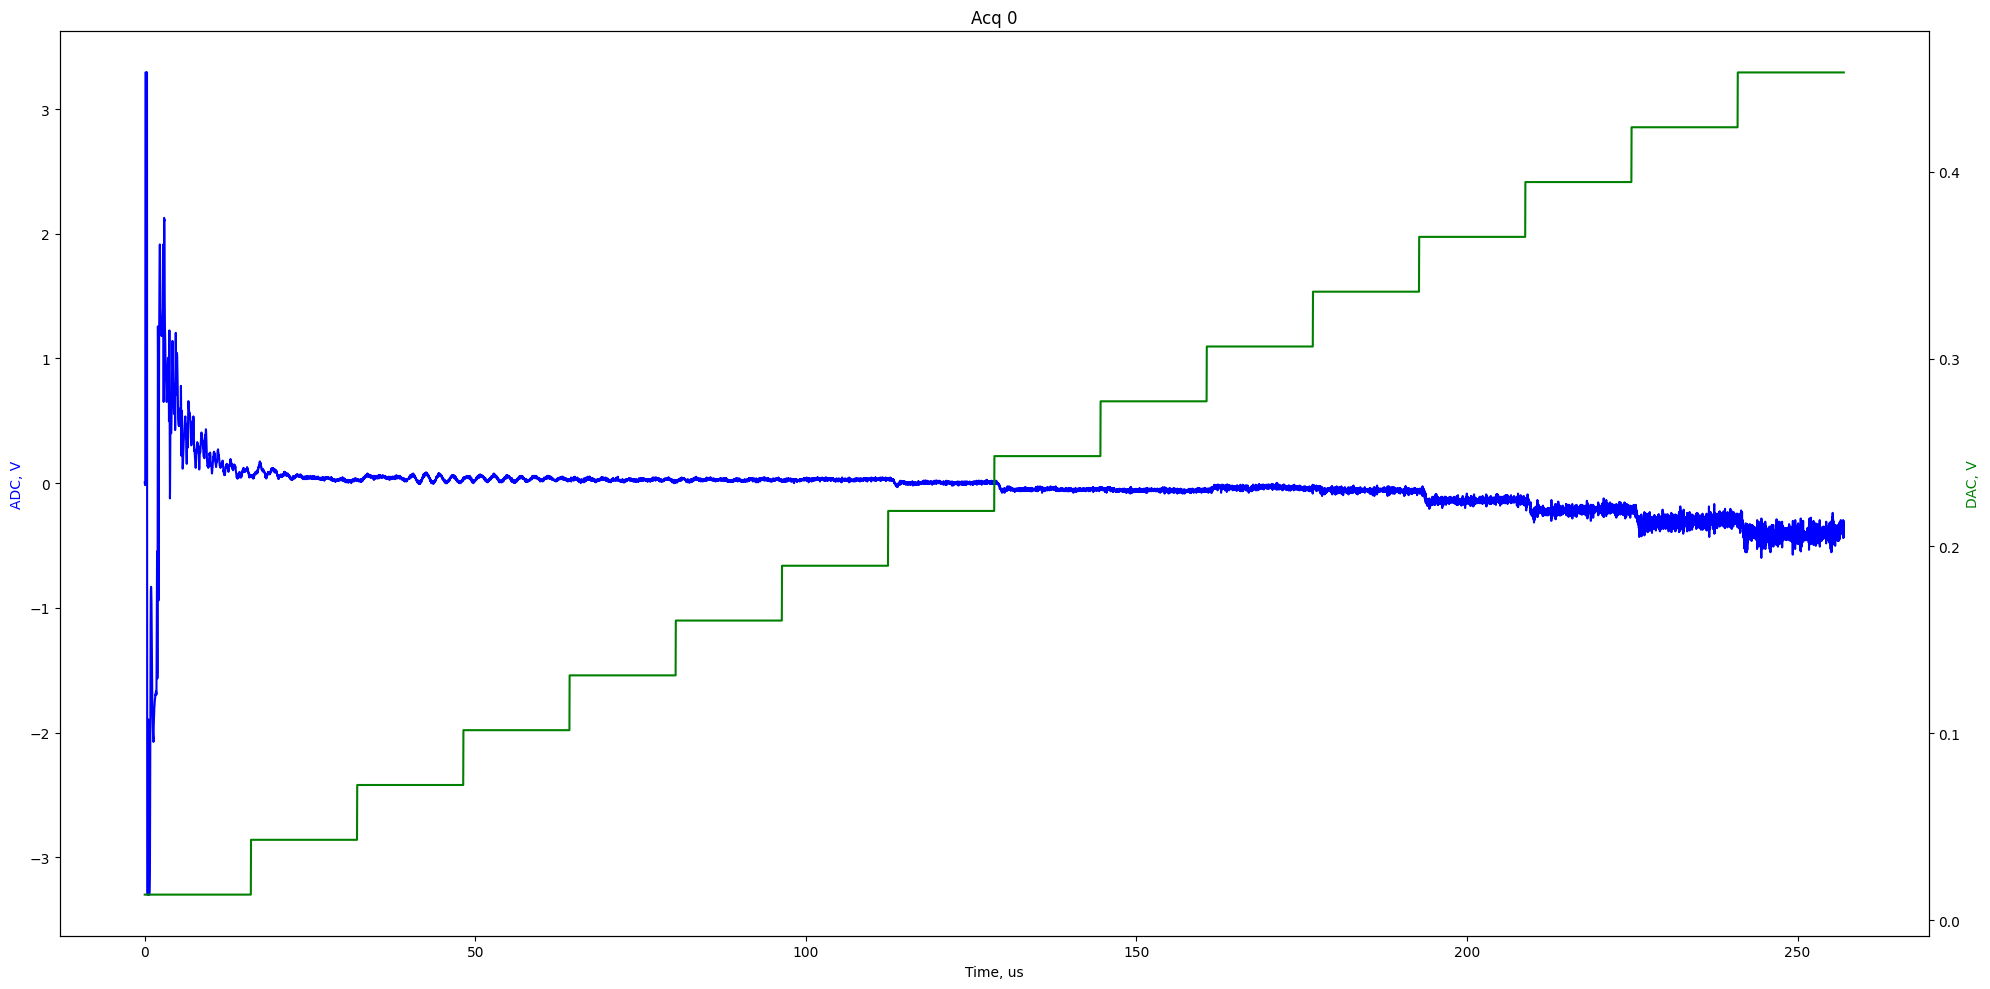

In [27]:
gain = gain_staircase(2, 510)
acq_res = fpga.do_acquisition(acq_lines=2, gain=gain, double_rate=False)
plot_line("Acq 0", acq_res[0], gain)

In [28]:
MaxLength = 350
data ={}
for i in range(MaxLength):
    gain = gain_staircase(2, 650)

    ValWidth = i
    fpga.csr.ponw = ValWidth
    fpga.csr.interw = ValWidth
    fpga.csr.poffw = 5000-2*ValWidth

    acq_res = fpga.do_acquisition(acq_lines=2, gain=gain, double_rate=False)

    #print(acq_res[0] == acq_res[1])
    data[ValWidth] = acq_res[0][4700:5300]
    #plot_line("Acq 0", acq_res[0], gain)
    #plot_line("Acq 1", acq_res[1], gain)
    #plot_line("Acq 0 with zoom", acq_res[0], gain, [30.0, 50.0])
    sleep(0.05)

In [29]:
import json

with open('all_width.json', 'w') as fp:
    json.dump(data, fp)

with open('all_width.json', 'r') as fp:
    data = json.load(fp)

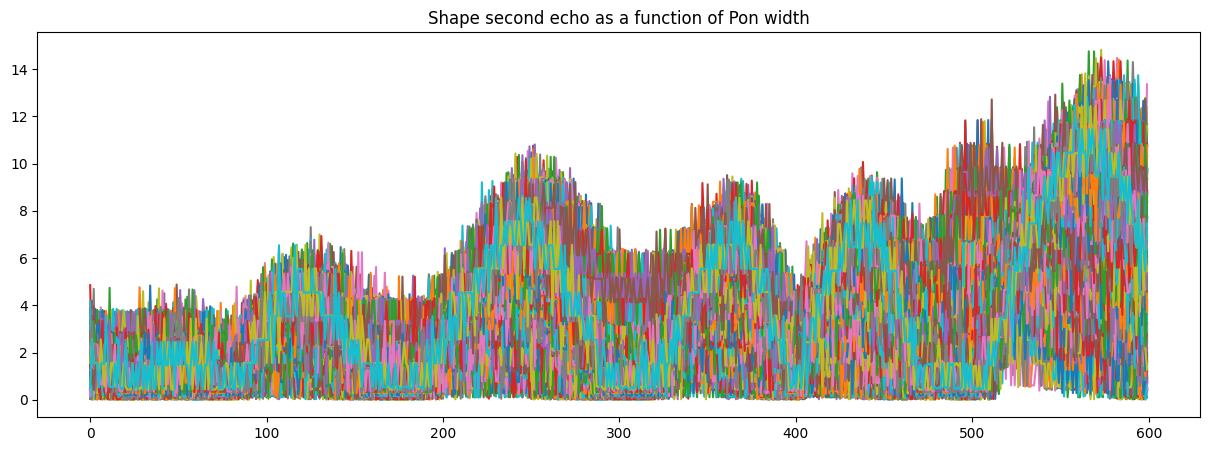

In [30]:
plt.figure(figsize=(15,5))
data["max"] = []
for k in range(MaxLength):
    k = str(k)
    data["peak_"+str(k)] = np.abs(data[k]-np.mean(data[k]))
    plt.plot(data["peak_"+str(k)])
    data["max"].append(np.max(data["peak_"+str(k)]))
plt.title("Shape second echo as a function of Pon width")
#plt.savefig("2nd_echo.png")
plt.show()

--POn Width--

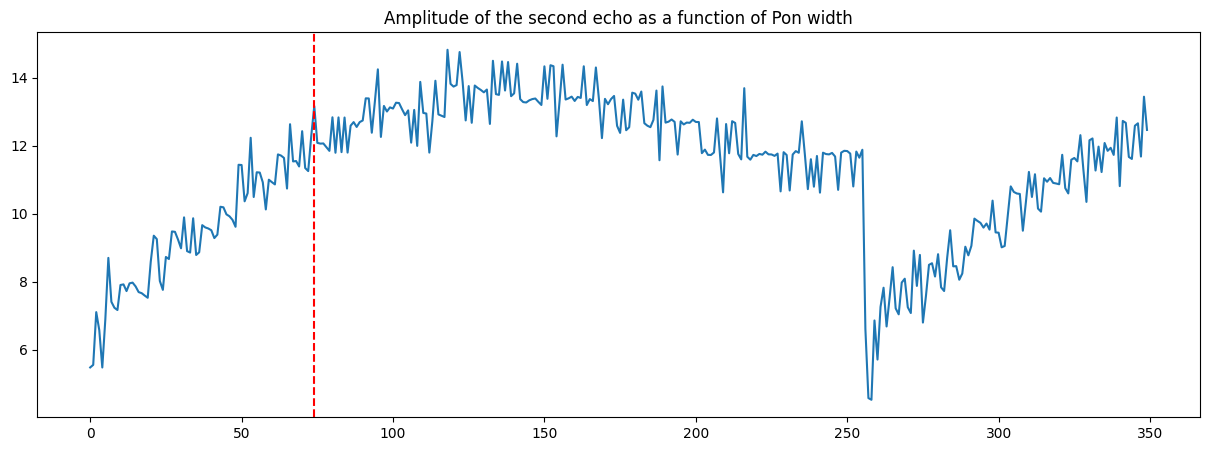

74


In [31]:
plt.figure(figsize=(15,5))
plt.plot(data["max"]) 
m = np.argmax(data["max"][0:80])
plt.axvline(m, color='r', linestyle='dashed')
plt.title("Amplitude of the second echo as a function of Pon width")
#plt.savefig("amplitude.png")
plt.show()
print(m)

--POn / PInterW--

In [32]:
data ={}
RANGE = 30
MIDRANGE = int(RANGE/2)

for i in range(RANGE):
    gain = gain_staircase(2, 650)

    ValWidth = i
    fpga.csr.ponw = 16+(i-MIDRANGE)
    fpga.csr.interw = 16-(i-MIDRANGE)
    fpga.csr.poffw = 5000-2*ValWidth

    acq_res = fpga.do_acquisition(acq_lines=2, gain=gain, double_rate=False)

    #print(acq_res[0] == acq_res[1])
    data[16+(i-MIDRANGE)] = acq_res[0][4700:5300]
    #plot_line("Acq 0", acq_res[0], gain)
    #plot_line("Acq 1", acq_res[1], gain)
    #plot_line("Acq 0 with zoom", acq_res[0], gain, [30.0, 50.0])
    sleep(0.05)
KEYS = [x for x in data.keys()]

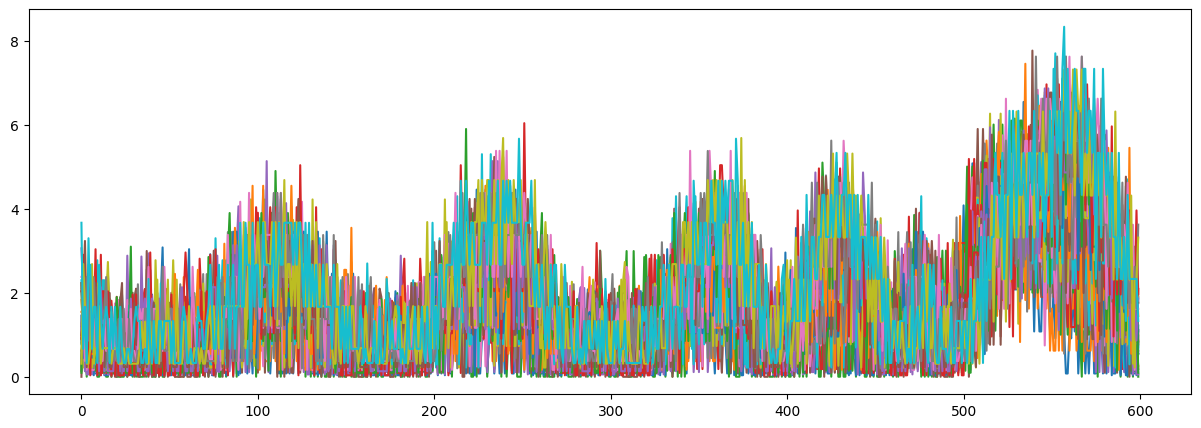

In [33]:
plt.figure(figsize=(15,5))
data["max"] = []
for k in KEYS: 
    data["peak_"+str(k)] = np.abs(data[k]-np.mean(data[k]))
    plt.plot(data["peak_"+str(k)])
    data["max"].append(np.max(data["peak_"+str(k)]))
plt.show()

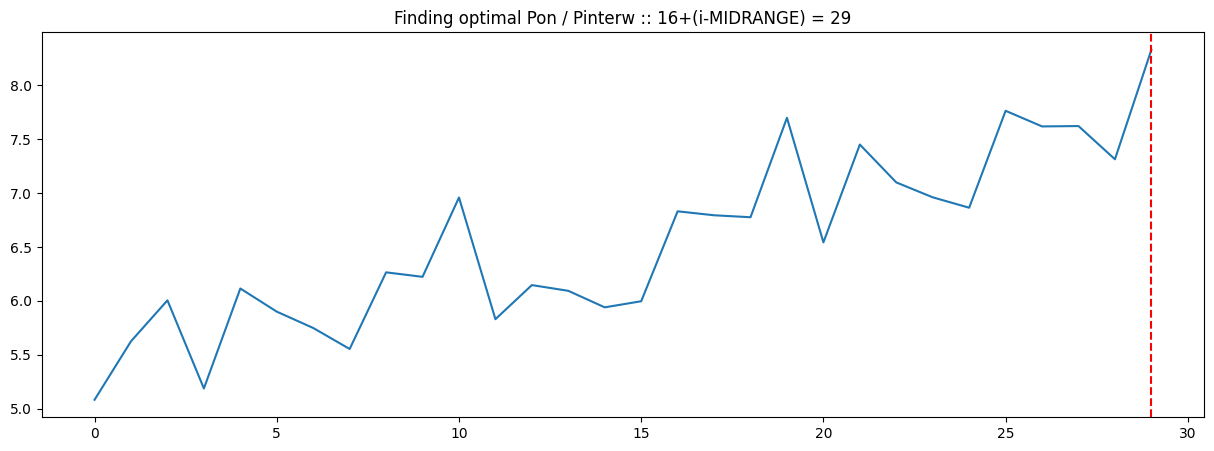

In [34]:
plt.figure(figsize=(15,5))
plt.plot(data["max"]) 
m = np.argmax(data["max"][0:80])
plt.axvline(m, color='r', linestyle='dashed')
plt.title("Finding optimal Pon / Pinterw :: 16+(i-MIDRANGE) = "+str(m))
plt.show()

In [35]:
data ={}
RANGE = 100

for i in range(RANGE):

    ValWidth = i
    fpga.csr.ponw = 16
    fpga.csr.interw = i
    fpga.csr.poffw = 5000-16-i

    acq_res = fpga.do_acquisition(acq_lines=4, gain=gain, double_rate=False)

    #print(acq_res[0] == acq_res[1])
    data[i] = ((np.array(acq_res[0])+np.array(acq_res[1])+np.array(acq_res[2])+np.array(acq_res[3]))/4)[4700:5300]
    #plot_line("Acq 0", acq_res[0], gain)
    #plot_line("Acq 1", acq_res[1], gain)
    #plot_line("Acq 0 with zoom", acq_res[0], gain, [30.0, 50.0])
    sleep(0.05)
KEYS = [x for x in data.keys()]

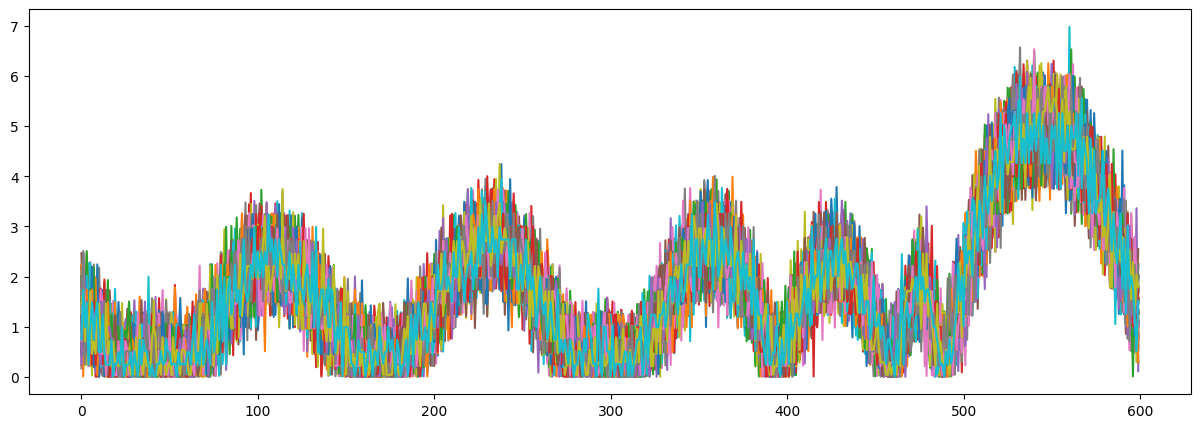

In [36]:
plt.figure(figsize=(15,5))
data["max"] = []
for k in KEYS: 
    data["peak_"+str(k)] = np.abs(data[k]-np.mean(data[k]))
    plt.plot(data["peak_"+str(k)])
    data["max"].append(np.max(data["peak_"+str(k)]))
plt.show()

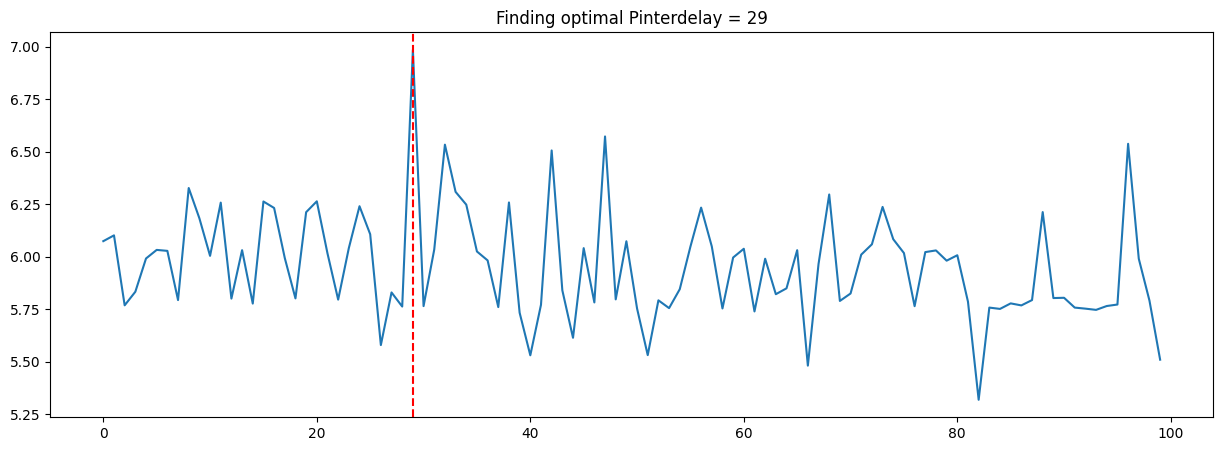

In [37]:
plt.figure(figsize=(15,5))
plt.plot(data["max"]) 
m = np.argmax(data["max"][0:80])
plt.axvline(m, color='r', linestyle='dashed')
plt.title("Finding optimal Pinterdelay = "+str(m))
#plt.savefig("pint.png")
plt.show()

--PDamp--

In [38]:
data ={}
RANGE = 50

for i in range(RANGE):

    fpga.csr.ponw = 16
    fpga.csr.interw = 16
    fpga.csr.poffw = 100*i

    acq_res = fpga.do_acquisition(acq_lines=4, gain=gain, double_rate=False)

    #print(100*i,acq_res[0] == acq_res[1])
    data[100*i] = ((np.array(acq_res[0])+np.array(acq_res[1])+np.array(acq_res[2])+np.array(acq_res[3]))/4)[4700:5300]
    #plot_line("Acq 0", acq_res[0], gain)
    #plot_line("Acq 1", acq_res[1], gain)
    #plot_line("Acq 0 with zoom", acq_res[0], gain, [30.0, 50.0])
    sleep(0.05)
KEYS = [x for x in data.keys()]

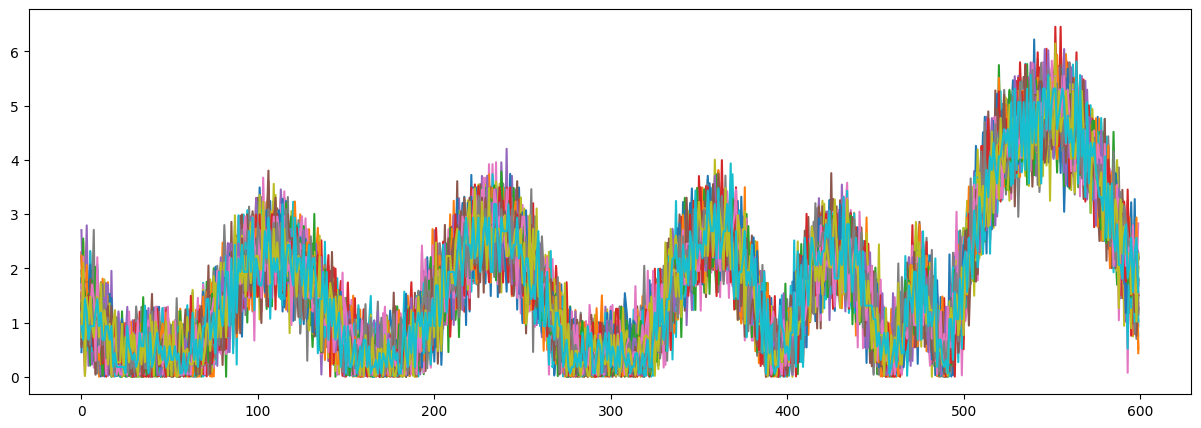

In [39]:
plt.figure(figsize=(15,5))
data["max"] = []
for k in KEYS: 
    data["peak_"+str(k)] = np.abs(data[k]-np.mean(data[k]))
    plt.plot(data["peak_"+str(k)])
    data["max"].append(np.max(data["peak_"+str(k)]))
plt.show()

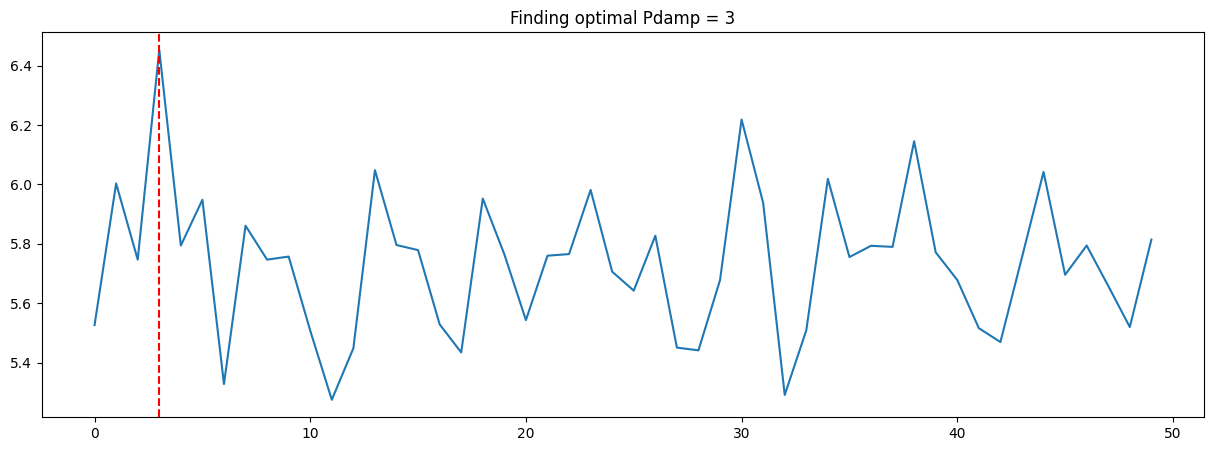

In [40]:
plt.figure(figsize=(15,5))
plt.plot(data["max"]) 
m = np.argmax(data["max"][0:80])
plt.axvline(m, color='r', linestyle='dashed')
plt.title("Finding optimal Pdamp = "+str(m))
#plt.savefig("pdamp.png")
plt.show()

--Main Acq--

In [41]:
import un0usb as USB # neeeds `pip3 install un0usb` before
import matplotlib.pyplot as plt
from pyUn0 import make_clean
# Check the version
USB.__version__
# init FTDI device

Not loading RPi.GPIO as not on RPi
pyexiv2 does not exist on RPi


'0.2.7'

In [42]:
fpga = USB.FpgaControl('ftdi://ftdi:2232:/', spi_freq=8E6)
# reload configuration (optional step - just to fill BRAM (DACGAIN registers) with initial values)
fpga.reload()
# reset fpga
fpga.reset()
fpga.set_pulseform(initDelay=5, POn=16, PInter=8, Poff=5)
gain = [int(200 + ((1000-100)*x*x*x/32/32/32)) for x in range(32)]
acq_res = fpga.do_acquisition(acq_lines=1, gain=gain, double_rate=True) 

8 ~ 42ns
16 ~ 167ns
25 ~ 208ns
32 ~ 250ns
50 units ~ 420ns
100 ~ 794ns
250 ~  1.5us
1000 ~ 1833ns
2500 ~ 1.5us
Keyword arguments:
initDelay -- ncycles before acquisition starts
POn -- width of the pulse
PInter -- time between Pon and PDamp
Poff -- damping period

In [43]:
print("There are",len(acq_res),"lines.")
LineOne = acq_res[0]
plt.plot(LineOne)

fpga.save("50%_25_1") 
plot = USB.FView() 
plot.readfile('50%_25_1.npz')

There are 1 lines.


/usr/local/lib/python3.10/dist-packages/un0usb/viz.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


NpzFile '50%_25_1.npz' with keys: signal, t, nblines, gain, t_on...